In [1]:
import pandas as pd
import numpy as np

from keras.models import Model
from keras.layers import Input, LSTM, Dense

import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
%cd /content/drive/MyDrive/Colab/Transliterate/

/content/drive/MyDrive/Colab/Transliterate


In [3]:
%ls

model_plot_dec.png  model.png  players_with_hindi_names.json  s2s.h5


In [4]:
df = pd.read_json('players_with_hindi_names.json')

In [5]:
df.head()

,id,hindi_name,hindi_long_name,english_name,gender,date_of_birth,country_id,slug
0,90143,आर गुरबाज़,रहमानउल्लाह गुरबाज़,Rahmanullah Gurbaz,M,"{'year': 2001, 'month': 11, 'date': 28}",40,rahmanullah-gurbaz
1,54018,एम रिज़वान,मोहम्मद रिज़वान,Mohammad Rizwan,M,"{'year': 1992, 'month': 6, 'date': 1}",7,mohammad-rizwan
2,47686,एस मक़सूद,सोहेब मक़सूद,Sohaib Maqsood,M,"{'year': 1987, 'month': 4, 'date': 15}",7,sohaib-maqsood
3,53649,आर आर रुसो,राइली रुसो,"Rossouw, RR",M,"{'year': 1989, 'month': 10, 'date': 9}",3,rilee-rossouw
4,72393,एस हेटमायर,शिमरॉन हेटमायर,"Hetmyer, SO",M,"{'year': 1996, 'month': 12, 'date': 26}",4,shimron-hetmyer


In [6]:
input_list =  df['hindi_long_name'].tolist()
target_list =  df['english_name'].tolist()

In [7]:
print(input_list[0])
print(target_list[0])

रहमानउल्लाह गुरबाज़
Rahmanullah Gurbaz


In [8]:
def isEnglish(s):
  try:
      s.encode(encoding='utf-8').decode('ascii')
  except UnicodeDecodeError:
      return False
  else:
      return True

def get_mapping_words(input_list, target_list):
  # Build Vocabulary
  input_words = list()
  target_words = list()
  for input_word, target_word in zip(input_list, target_list):
    # there are some target words in hindi
    if isEnglish(target_word): 
      # there are 3 ways names are given
      # 1. Firstname lastname  Ex ('रहमानउल्लाह गुरबाज़', 'Rahmanullah Gurbaz')
      # 2. Lastname, Firstname Initials  Ex ('राइली रुसो', 'Rossouw, RR')
      # 3. Lastname. Firstname Initials  Ex ('राइली रुसो', 'Rossouw.RR')
      # if comma exists then discard initials
      if "," in target_word or "." in target_word:
        hln = input_word.split()[1]
        if "," in target_word:
          eln = target_word.lower().split(',')[0]
        else:
          eln = target_word.lower().split('.')[0]
        input_words.append(hln)
        target_words.append(eln)
      else:
        input_names = input_word.split()
        target_names = target_word.split()
        # For example - 'लिटन कुमार दास' != Liton Das, remove middle name
        if len(input_names) > len(target_names):
          del input_names[1] # delete middle name
        for idx in range(len(input_names)):
          hn = input_names[idx]
          en = target_names[idx].lower()
          input_words.append(hn)
          target_words.append(en)
  return input_words, target_words

In [9]:
input_words, target_words = get_mapping_words(input_list, target_list)

In [10]:
# verifying the data
print(input_words[20])
print(target_words[20])

शारजील
sharjeel


In [11]:
print(f"Total number of input words {len(input_words)}")
print(f"Total number of target words {len(target_words)}")

Total number of input words 2914
Total number of target words 2914


In [12]:
def build_vocab(input_words, target_words):
  input_vocab = set()
  target_vocab = set()
  for input_word, target_word in zip(input_words, target_words):
      input_vocab.update(set(input_word))
      target_vocab.update(set(target_word))
  return input_vocab, target_vocab

In [13]:
input_vocab, target_vocab = build_vocab(input_words, target_words)

In [14]:
# append start of word (^) and end of word tokens ($)
target_vocab.add('^')
target_vocab.add('$')

In [15]:
print(f"Total hindi characters {len(input_vocab)}")
print(f"Total english characters {len(target_vocab)}")

Total hindi characters 53
Total english characters 31


In [16]:
input_vocab = sorted(list(input_vocab))
target_vocab = sorted(list(target_vocab))

In [17]:
input_token_index = dict([(char, i) for i, char in enumerate(input_vocab)])
target_token_index = dict([(char, i) for i, char in enumerate(target_vocab)])

In [18]:
num_encoder_tokens = len(input_vocab)
num_decoder_tokens = len(target_vocab)

In [19]:
max_encoder_seq_length = max([len(txt) for txt in input_words])
max_decoder_seq_length = max([len(txt) for txt in target_words])
# for start & end of the word
max_decoder_seq_length += 1

In [20]:
print('Number of samples:', len(input_words))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 2914
Number of unique input tokens: 53
Number of unique output tokens: 31
Max sequence length for inputs: 13
Max sequence length for outputs: 16


In [21]:
encoder_input_data = np.zeros((len(input_words), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(input_words), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros( (len(input_words), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

In [22]:
print(f"encoder input shape {encoder_input_data.shape}")
print(f"decoder input shape {decoder_input_data.shape}")
print(f"decoder target shape {decoder_target_data.shape}")

encoder input shape (2914, 13, 53)
decoder input shape (2914, 16, 31)
decoder target shape (2914, 16, 31)


In [23]:
for i, (input_text, target_text) in enumerate(zip(input_words, target_words)):
  for t, char in enumerate(input_text):
    encoder_input_data[i, t, input_token_index[char]] = 1.
  target_text_w_sow = '^' + target_text 
  target_text_w_eow = target_text + '$'
  for t, char in enumerate(target_text_w_sow):
    decoder_input_data[i, t, target_token_index[char]] = 1.
  for t, char in enumerate(target_text_w_eow):
    decoder_target_data[i, t, target_token_index[char]] = 1.

In [24]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))

In [25]:
latent_dim = 256  # Latent dimensionality of the encoding space.

encoder = LSTM(latent_dim, return_state=True)

In [26]:
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

In [27]:
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [28]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))

In [29]:
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)

In [30]:
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

In [31]:
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [32]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 53)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 31)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 317440      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  294912      input_2[0][0]                    
                                                                 lstm[0][1]                   

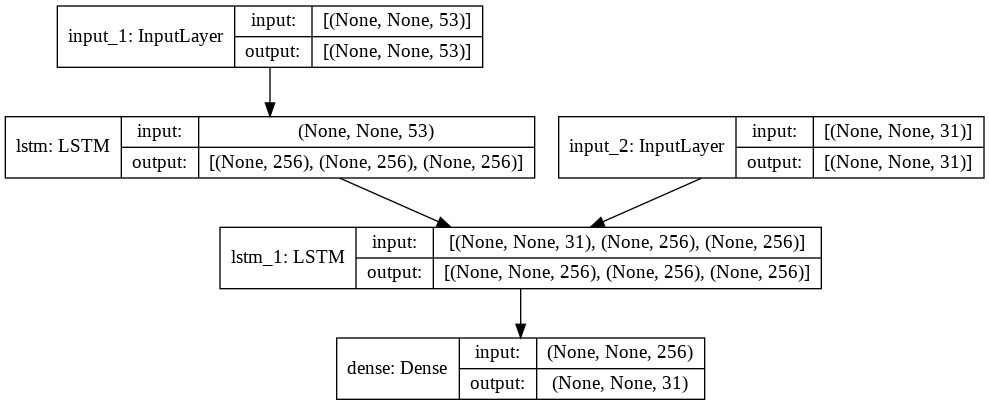

In [34]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [35]:
# Training
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size, epochs=epochs, validation_split=0.2)
# Save model
model.save('s2s.h5')

Epoch 1/100
37/37 [==============================] - 10s 172ms/step - loss: 1.3424 - val_loss: 1.1413
Epoch 2/100
37/37 [==============================] - 6s 152ms/step - loss: 1.2499 - val_loss: 1.0936
Epoch 3/100
37/37 [==============================] - 5s 147ms/step - loss: 1.1921 - val_loss: 1.0411
Epoch 4/100
37/37 [==============================] - 6s 150ms/step - loss: 1.1364 - val_loss: 0.9809
Epoch 5/100
37/37 [==============================] - 6s 152ms/step - loss: 1.0934 - val_loss: 0.9610
Epoch 6/100
37/37 [==============================] - 5s 148ms/step - loss: 1.0511 - val_loss: 0.9181
Epoch 7/100
37/37 [==============================] - 5s 149ms/step - loss: 1.0028 - val_loss: 0.8975
Epoch 8/100
37/37 [==============================] - 6s 151ms/step - loss: 0.9583 - val_loss: 0.9276
Epoch 9/100
37/37 [==============================] - 6s 149ms/step - loss: 0.9202 - val_loss: 0.8569
Epoch 10/100
37/37 [==============================] - 5s 148ms/step - loss: 0.8888 - val_l

In [36]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


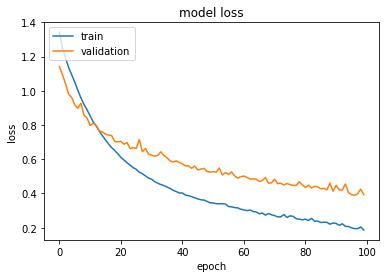

In [38]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [39]:
%ls -ltr

total 5753
-rw------- 1 root root  813709 Sep 14 22:38 players_with_hindi_names.json
-rw------- 1 root root   33437 Sep 17 01:43 model_plot_dec.png
-rw------- 1 root root   36092 Sep 17 01:44 model.png
-rw------- 1 root root 5006688 Sep 17 01:54 s2s.h5


In [40]:
!du -sh s2s.h5

4.8M	s2s.h5


In [41]:
# Predictions
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(None, num_decoder_tokens))
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single, initial_state=decoder_states_inputs)

decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

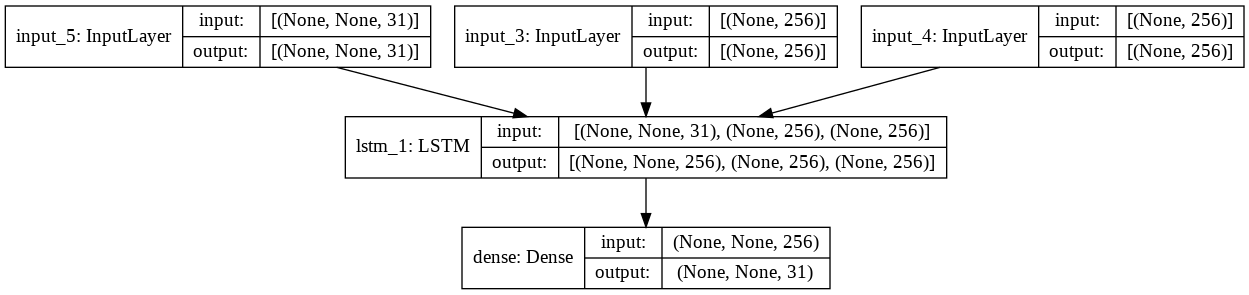

In [42]:
tf.keras.utils.plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

In [43]:
input_data = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
decoder_data = np.zeros((1, 1, num_decoder_tokens), dtype='float32')
test_input = 'राजशेखर'
for t, char in enumerate(test_input):
  input_data[0, t, input_token_index[char]] = 1.

In [44]:
states_values = encoder_model(input_data)
target_token_index_rev = {target_token_index[k]: k for k in target_token_index}

In [45]:
def predict_target(decoder_data, states_values):
  decoder_data[0, 0, 0] = target_token_index['^']
  eos = target_token_index['$']
  output_word = []

  for _ in range(max_decoder_seq_length):
    output_tokens, h, c = decoder_model.predict([decoder_data, states_values[0], states_values[1]])
    idx = np.argmax(output_tokens[0, 0, :])
    if eos == idx:
      break
    char = ''
    if idx > 0:
      char = target_token_index_rev[idx]
      output_word.append(char)
    decoder_data[0, 0, 0] = idx
    states_values = [h, c]
  return ''.join(output_word)

In [46]:
predicted_string = predict_target(decoder_data, states_values)
predicted_string

'rsssssssssssssss'